In [20]:
!pip install Bio
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path
%cd "/content/drive/MyDrive/Colab Notebooks" 
import import_ipynb
import SH3_MODELING_utils

/content/drive/MyDrive/Colab Notebooks


In [23]:
###############################################################################
#                                                                             #
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################


# number of ResNet blocks for the first ResNet and the kernel size.
RESNET_1_BLOCKS = 3 
RESNET_1_KERNEL_SIZE = 15
RESNET_1_KERNEL_NUM = 64


###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 1 
RESNET_2_KERNEL_SIZE = 5  # good start may be 3/5
RESNET_2_KERNEL_NUM = 64
DILATION = [1,2,4,8,16]

# percentage of dropout for the dropout layer
DROPOUT = 0.2 # good start may be 0.1-0.5

# number of epochs, Learning rate and Batch size
EPOCHS = 200
LR = 0.001 # good start may be 0.0001/0.001/0.01
BATCH = 16 # good start may be 32/64/128

In [24]:
def resnet_1(input_layer):  # TODO: implement this!
    """
    ResNet layer - input -> BatchNormalization -> Conv1D -> Relu -> BatchNormalization -> Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_1_BLOCKS):
      batch1_layer = tf.keras.layers.BatchNormalization()(input_layer)
      conv1d1_layer = layers.Conv1D(RESNET_1_KERNEL_NUM,RESNET_1_KERNEL_SIZE,padding='same')(batch1_layer)
      activation1_layer = layers.Activation("relu")(conv1d1_layer)

      batch2_layer = tf.keras.layers.BatchNormalization()(activation1_layer)
      conv1d2_layer = layers.Conv1D(RESNET_1_KERNEL_NUM,RESNET_1_KERNEL_SIZE,padding='same')(batch2_layer)
      activation2_layer = layers.Activation("relu")(conv1d2_layer)
      input_layer = tf.keras.layers.Add()([input_layer,activation2_layer])
    return input_layer

In [25]:
def resnet_2(input_layer):  # TODO: implement this!
    """
    Dilated ResNet layer - input -> BatchNormalization -> dilated Conv1D -> Relu -> BatchNormalization -> dilated Conv1D -> Relu -> Add
    :param input_layer: input layer for the ResNet
    :return: last layer of the ResNet
    """
    for i in range(RESNET_2_BLOCKS):
      for j in DILATION:
        batch1_layer = tf.keras.layers.BatchNormalization()(input_layer)
        conv1d1_layer = layers.Conv1D(RESNET_2_KERNEL_NUM,RESNET_2_KERNEL_SIZE,padding='same',dilation_rate=j)(batch1_layer)
        activation1_layer = layers.Activation("relu")(conv1d1_layer)

        batch2_layer = tf.keras.layers.BatchNormalization()(activation1_layer)
        conv1d2_layer = layers.Conv1D(RESNET_2_KERNEL_NUM,RESNET_2_KERNEL_SIZE,padding='same',dilation_rate=j)(batch2_layer)
        activation2_layer = layers.Activation("relu")(conv1d2_layer)
        input_layer = tf.keras.layers.Add()([input_layer,activation2_layer])
    return input_layer

In [26]:
def build_network():
    """
    builds the neural network architecture as shown in the exercise.
    :return: a Keras Model
    """
    # input, shape (NB_MAX_LENGTH,FEATURE_NUM)
    input_layer = tf.keras.Input(shape=(SH3_MODELING_utils.MAX_LENGTH_D + SH3_MODELING_utils.MAX_LENGTH_P, SH3_MODELING_utils.FEATURE_NUM))

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_1_KERNEL_NUM, RESNET_1_KERNEL_SIZE, padding='same')(input_layer)

    # first ResNet -> shape = (NB_MAX_LENGTH, RESNET_1_KERNEL_NUM)
    resnet_layer = resnet_1(conv1d_layer)

    # Conv1D -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    conv1d_layer = layers.Conv1D(RESNET_2_KERNEL_NUM, RESNET_2_KERNEL_SIZE, padding="same")(resnet_layer)

    # second ResNet -> shape = (NB_MAX_LENGTH, RESNET_2_KERNEL_NUM)
    resnet_layer = resnet_2(conv1d_layer)


    # TODO: fill the missing layers

    dropout_layer = tf.keras.layers.Dropout(DROPOUT)(resnet_layer)

    conv1d2_layer = layers.Conv1D(RESNET_2_KERNEL_NUM/2,RESNET_2_KERNEL_SIZE,padding='same')(dropout_layer)
    activation_layer = layers.Activation("elu")(conv1d2_layer)

    output_layer = tf.keras.layers.Dense(15)(activation_layer)

    model = tf.keras.Model(input_layer,output_layer)
    return model


In [27]:
def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 1, figsize=(15,3))
    axes.plot(history.history['loss'], label='Training loss')
    axes.plot(history.history['val_loss'], label='Validation loss')
    axes.legend()
    axes.set_title("Train and Val MSE loss")

    plt.savefig("/content/drive/MyDrive/3D protein Hackathon/model_loss_history")  # TODO: you can change the path here


Epoch 1/200
8/9 [=========================>....] - ETA: 0s - loss: 2916.9260
Epoch 1: val_loss improved from inf to 13315.66699, saving model to /content/drive/MyDrive/3D protein Hackathon/sh3_model_second
INFO:tensorflow:Assets written to: /content/drive/MyDrive/3D protein Hackathon/sh3_model_second/assets
9/9 [==============================] - 18s 1s/step - loss: 2845.4905 - val_loss: 13315.6670
Epoch 2/200
7/9 [======================>.......] - ETA: 0s - loss: 697.3177
Epoch 2: val_loss improved from 13315.66699 to 1830.24036, saving model to /content/drive/MyDrive/3D protein Hackathon/sh3_model_second
INFO:tensorflow:Assets written to: /content/drive/MyDrive/3D protein Hackathon/sh3_model_second/assets
9/9 [==============================] - 8s 1s/step - loss: 652.6841 - val_loss: 1830.2404
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 297.3154
Epoch 3: val_loss did not improve from 1830.24036
9/9 [==============================] - 0s 30ms/step - loss: 297.3154 

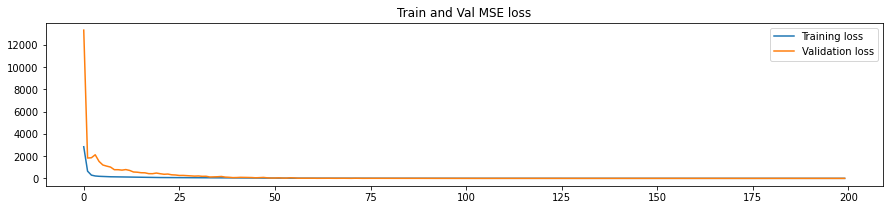

In [28]:
if __name__ == '__main__':

    model = build_network()
    data_dir ="/content/drive/MyDrive/3D protein Hackathon"

    # you can load here your input and output data

    # X = numpy array of shape (1974,NB_MAX_LENGTH,FEATURE_NUM) of all the data input.
    # Y = numpy array of shape (1974,NB_MAX_LENGTH,OUTPUT_SIZE) of all the data labels.
    X_train = np.load("/content/drive/MyDrive/3D protein Hackathon/train_input.npy")
    y_train = np.load("/content/drive/MyDrive/3D protein Hackathon/train_labels.npy")

    X_test = np.load("/content/drive/MyDrive/3D protein Hackathon/test_input.npy")
    y_test = np.load("/content/drive/MyDrive/3D protein Hackathon/test_labels.npy")

    # split into validation and test sets as you like
    # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
    

    # b)
    #  compile model using Adam optimizer (with learning rate of your choice) and MSE loss.
    my_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer = my_optimizer, loss='mean_squared_error')


    # c)
    # fit model (use EPOCH for epoch parameter and BATCH for batch_size parameter)
    # checkpoint_filepath = '/content/drive/MyDrive/Ex4Files/checkpoint'
    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    # filepath=checkpoint_filepath,
    # save_weights_only=True,
    # monitor='val_loss',
    # mode=min,
    # save_best_only=True)
    save_model = tf.keras.callbacks.ModelCheckpoint(filepath=f"{data_dir}/sh3_model_second", save_best_only=True, verbose=1)
    
    history = model.fit(X_train,y_train,epochs = EPOCHS, batch_size = BATCH, validation_data=(X_test,y_test),callbacks=[save_model])
    plot_val_train_loss(history)

    # d)
    # save model
    # model.load_weights(checkpoint_filepath)
    print(model.summary())
    # save_model.save("/content/drive/MyDrive/3D protein Hackathon/sh3_model",save_format = 'tf')

    # part 3 predict
    score = model.evaluate(X_test, y_test) 
